In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics


In [ ]:
import os

# Directory path where files are supposed to be uploaded
directory_path = '/content/gdrive/MyDrive/emotions_dataset'

# Check if directory exists
if os.path.exists(directory_path) and os.path.isdir(directory_path):
    # List all files in the directory
    uploaded_files = os.listdir(directory_path)
    if uploaded_files:
        print(f"Files uploaded: {uploaded_files}")
    else:
        print("No files uploaded.")
else:
    print(f"Directory does not exist: {directory_path}")


Files uploaded: ['sad', 'happy', 'disgust', 'neutral', 'angry_modified', 'fear']


In [ ]:
data_directory='/content/gdrive/MyDrive/emotions_dataset'

In [ ]:
emotions = {
    'sad': 0,
    'happy': 1,
    'disgust': 2,
    'neutral': 3,
    'angry_modified': 4,
    'fear':5
}


In [ ]:
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    """
    Extract features from audio files into numpy array.

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """
    result = np.array([])
    if chroma:
        stft = np.abs(librosa.stft(data))
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma_features))
    if mel:
        mel_features = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel_features))

    return result


In [ ]:
def noise(data, noise_factor):
    """
    Add random white noise to the audio.

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shift(data, sampling_rate, shift_max, shift_direction):
    """
    Shift the spectrogram in a direction.

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data


In [ ]:
import glob
import librosa
import os
import numpy as np

def load_data(save=False):
    """
    Loading dataset and applying augmentation.

    Parameters
    ----------
    save : boolean, save the data to disk as .npy
    """
    x, y = [], []
    label_mapping = {"sad": 0, "happy": 1, "disgust": 2, "neutral": 3, "angry_modified": 4,  "fear": 5}

    # Traverse folders based on emotion (sad, happy, etc.)
    for label in label_mapping:
        folder_path = os.path.join(data_directory, label)  # Path to the emotion folder
        for file in glob.glob(os.path.join(folder_path, "*.wav")):  # List of files in the folder
            data, sr = librosa.load(file)  # Load the audio file
            feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
            x.append(feature)

            # Get emotion label from the folder name
            y.append(label_mapping[label])

            # Apply noise augmentation
            n_data = noise(data, 0.001)
            n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
            x.append(n_feature)
            y.append(label_mapping[label])

            # Apply shift augmentation
            s_data = shift(data, sr, 0.25, 'right')
            s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
            x.append(s_feature)
            y.append(label_mapping[label])

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    # Optionally save the data to disk
    if save:
        np.save('X', x)
        np.save('y', y)

    return x, y


In [ ]:
# Load data
X, y = load_data(save=True)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

# Label encoding
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# Get the number of features
print(f'Features extracted: {x_train.shape}')


Features extracted: (587, 180)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv1DModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(Conv1DModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.conv6 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.conv7 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.conv8 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool1d(kernel_size=2)

        # Final pooling layer
        self.pool5 = nn.MaxPool1d(kernel_size=2)

        # Dropout and flatten layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        # Compute the output size after the last pooling layer
        # Calculate pooled size dynamically
        pooled_length = input_length // (2 ** 5)  # 5 pooling layers
        self.fc = nn.Linear(128 * pooled_length, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool4(x)

        x = self.pool5(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate model
input_length = 180  # Adjust if necessary
num_classes = 8  # Number of emotions
model = Conv1DModel(input_length=input_length, num_classes=num_classes)

# Sample input to check the model
sample_input = torch.randn(64, 1, 180)  # Batch size of 64, 1 channel, input length of 180
output = model(sample_input)
print(output.shape)  # Should be (64, 8)
print(model)  # Print the model architecture


torch.Size([64, 8])
Conv1DModel(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv6): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool1d(kernel_size=2, stride=2, p

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # Add channel dimension

# Create dataset instances
train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_test, y_test)

# Create DataLoader instances
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn.functional as F

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

# Training settings
epochs = 100
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item() * x_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss /= total
    train_accuracy = correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= total
    val_accuracy = correct / total

    # Log metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # Print metrics with epoch number
    print(f"Epoch [{epoch + 1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch [1/100] - Train Loss: 1.8260, Train Accuracy: 0.1976, Val Loss: 1.6385, Val Accuracy: 0.3163
Epoch [2/100] - Train Loss: 1.6488, Train Accuracy: 0.2641, Val Loss: 1.5195, Val Accuracy: 0.3878
Epoch [3/100] - Train Loss: 1.5434, Train Accuracy: 0.3237, Val Loss: 1.4331, Val Accuracy: 0.4949
Epoch [4/100] - Train Loss: 1.4578, Train Accuracy: 0.3697, Val Loss: 1.3576, Val Accuracy: 0.4745
Epoch [5/100] - Train Loss: 1.3955, Train Accuracy: 0.4293, Val Loss: 1.2826, Val Accuracy: 0.5765
Epoch [6/100] - Train Loss: 1.2703, Train Accuracy: 0.5077, Val Loss: 1.2286, Val Accuracy: 0.5255
Epoch [7/100] - Train Loss: 1.1560, Train Accuracy: 0.5656, Val Loss: 1.1318, Val Accuracy: 0.5357
Epoch [8/100] - Train Loss: 1.1474, Train Accuracy: 0.5605, Val Loss: 1.0680, Val Accuracy: 0.6071
Epoch [9/100] - Train Loss: 1.0285, Train Accuracy: 0.6116, Val Loss: 1.0064, Val Accuracy: 0.6378
Epoch [10/100] - Train Loss: 0.8999, Train Accuracy: 0.6695, Val Loss: 0.9614, Val Accuracy: 0.6224
Epoch [11

In [ ]:
import torch
import librosa

# Function to load and preprocess a single audio file for prediction
def predict_emotion(audio_file_path, model, labelencoder, device):
    # Load the audio file
    data, sr = librosa.load(audio_file_path)

    # Extract features using your existing extract_feature function
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)

    # Reshape feature to match the input format of the model (batch_size, channels, length)
    feature = feature.reshape(1, 1, -1)  # Add batch dimension and channel dimension

    # Convert feature to a PyTorch tensor
    feature_tensor = torch.tensor(feature, dtype=torch.float32).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform the forward pass and get the model's output
    with torch.no_grad():
        output = model(feature_tensor)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    # Map the predicted class to the actual emotion label
    predicted_emotion = labelencoder.inverse_transform([predicted_class.item()])

    return predicted_emotion[0]

# Example usage:

# Replace 'your_audio_file.wav' with the path to your audio clip
audio_file_path ='/content/gdrive/MyDrive/emotions_dataset/disgust/22.wav'

# Get device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model (make sure it's on the correct device)
model.to(device)

# Predict the emotion for the given audio file
predicted_emotion = predict_emotion(audio_file_path, model, labelencoder, device)

# Print the predicted emotion
print(f"Predicted Emotion: {predicted_emotion}")


Predicted Emotion: 2


In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    """
    Collate function for batching variable length sequences (audio features) and labels.

    Parameters
    ----------
    batch : list of tuples, where each tuple contains (feature, label)
    """
    features, labels = zip(*batch)

    # Pad features to the same length (as audio files might have different lengths)
    features = pad_sequence(features, batch_first=True)

    # Convert labels to a tensor
    labels = torch.tensor(labels)

    return features, labels


In [ ]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

# Assuming 'TeluguEmotionDataset' is your custom dataset class and 'collate_fn' is the collate function
test_dataset = AudioDataset(x_test, y_test)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Now, you can call the evaluate_model function
evaluate_model(model, test_loader, labelencoder, device)


Test Accuracy: 97.96%


In [ ]:
import torch

# Function to evaluate model on test data and print accuracy
def evaluate_model(model, test_loader, labelencoder, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for features, labels in test_loader:
            # Move data to the appropriate device (CPU/GPU)
            features, labels = features.to(device), labels.to(device)

            # Get model predictions
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score

            # Update total predictions and correct predictions
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

# Example usage:
# Assuming 'model' is your trained model, and 'test_loader' is your DataLoader for the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculate and print test accuracy
evaluate_model(model, test_loader, labelencoder, device)


Test Accuracy: 97.96%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import numpy as np


In [ ]:
def plot_confusion_matrix(model, test_loader, labelencoder, device):
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []

    # Loop over the test dataset
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)

            # Get model predictions
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            # Append true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Define the label mapping (this should match the emotion classes in your dataset)
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(emotion_labels)

# If you need to save it for later use (e.g., after training), you can use joblib:
# import joblib
# joblib.dump(label_encoder, 'label_encoder.pkl')


LabelEncoder()

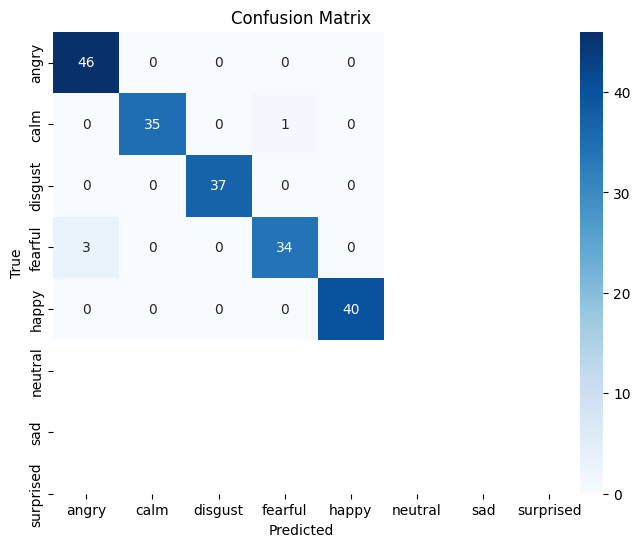

In [ ]:

# Example usage: after evaluating the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, label_encoder, device)


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Get model predictions on test data
# model.eval()
# all_labels = []
# all_predictions = []

# with torch.no_grad():
#     for features, labels in test_loader:
#         features, labels = features.to(device), labels.to(device)
#         outputs = model(features)
#         _, predicted = torch.max(outputs, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())

# # Calculate and print classification report
# print(classification_report(all_labels, all_predictions))

# # Plot confusion matrix
# cm = confusion_matrix(all_labels, all_predictions)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()


In [ ]:
# # Assuming your model is called `model`
# torch.save(model.state_dict(), 'my_model.pth')  # Save the model state

# # To save it to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Save the model to your Google Drive
# torch.save(model.state_dict(), '/content/drive/My Drive/my_model.pth')


In [ ]:
# input_length = 180  # Same as used during training
# num_classes = 8     # Number of emotions
# model = Conv1DModel(input_length=input_length, num_classes=num_classes)

# # Load the model state dictionary from the saved file
# model.load_state_dict(torch.load('/content/drive/My Drive/my_model.pth'))

# # Set the model to evaluation mode
# model.eval()

# # Check the model architecture
# print(model)

In [ ]:
# import os
# import librosa

# audio_file_path = '/content/gdrive/MyDrive/Tess/YAF_happy/YAF_bean_happy.wav'

# if os.path.exists(audio_file_path):
#     try:
#         data, sr = librosa.load(audio_file_path, sr=None)  # sr=None to preserve the original sample rate
#         print("Audio loaded successfully.")
#     except Exception as e:
#         print(f"Error loading audio file: {e}")
# else:
#     print("Audio file does not exist at the specified path.")


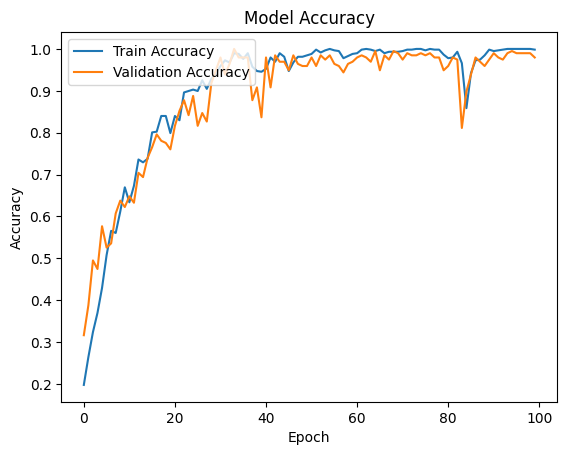

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a dictionary 'history' to store accuracy values
# For example:
# history = {'train_accuracy': [0.85, 0.87, ...], 'val_accuracy': [0.80, 0.83, ...]}

# Plotting the accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# import torch

# def evaluate_model(model, test_loader):
#     model.eval()  # Set the model to evaluation mode
#     correct_predictions = 0
#     total_predictions = 0

#     with torch.no_grad():  # Disable gradient calculation for evaluation
#         for features, labels in test_loader:
#             # Move data to the appropriate device (CPU/GPU)
#             features, labels = features.to(device), labels.to(device)

#             # Get model predictions
#             outputs = model(features)
#             _, predicted = torch.max(outputs, 1)  # Get the class with the highest score

#             # Update total predictions and correct predictions
#             total_predictions += labels.size(0)
#             correct_predictions += (predicted == labels).sum().item()

#     accuracy = correct_predictions / total_predictions * 100
#     print(f'Test Accuracy: {accuracy:.2f}%')

# # Example usage:
# evaluate_model(model, test_loader)  # Replace 'model' with your trained model
